# Figure 2

## Jonah Shaw, 09/27/2021

Looks at temperature, sea ice, ASR, and OLR trends in the CESM1-LE. (i.e. reproduce figures 1a-c)

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

In [3]:
model_variables = ['LANDFRAC','ICEFRAC','FLUT','SOLIN','FSNT','FSNTOA','TS']

## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [4]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [5]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [6]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

#### Create strings to identify ensemble members

In [32]:
def zero_strings(numz):
    
    out = ''
    for i in range(numz):
        out+='0'
    return out

ensemble_nums = []

for i in range(105): # 35ish members seem to have the right dates
    ii = str(i + 2) # things seem to start at 2 in the directory
    
    # this could be a single line
    ensemble_nums.append(zero_strings(3-len(ii))+ii)

In [43]:
# hardcoded alternate with only ensembles we can use
ensemble_nums2 = [
    '002', '003', '004', '005', '006', 
    '007', '008', '009', '010', '011', 
    '012', '013', '014', '015', '016', 
    '017', '018', '019', '020', '021', 
    '022', '023', '024', '025', '026', 
    '027', '028', '029', '030', '031', 
    '032', '033', '034', '035', '101', 
    '102', '103', '104', '105'
]

#### Find and collect paths for each variable and ensemble

In [45]:
path_dict = {} # first key is the ensemble number, second is the model variable

for _ensn in ensemble_nums2:
    for _var in model_variables:
        _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.192001-200512.nc' % (cesmle_path,_var,_ensn,_var))
        _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-2???12.nc' % (cesmle_path,_var,_ensn,_var))

        if (len(_t1_file) != 1) or (len(_t2_file) != 1):
            print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
            break
        try:
            path_dict[_ensn][_var]=[*_t1_file,*_t2_file]
        except:
            path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}    

#### Land fraction in constant between ensembles and in time, so we only need to store it once.

In [9]:
ex_files = path_dict['002']

_landfrac = xr.open_mfdataset(ex_files['LANDFRAC'])['LANDFRAC'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None)).isel(time=0)

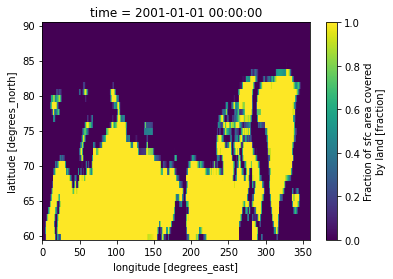

In [10]:
_landfrac.plot()

#### Compute trends in zonally-averaged OLR

In [54]:
# Why doesn't the time chunking stick around?
_olr_i = xr.open_mfdataset(ex_files['FLUT'])#['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))
_olr = fix_cesm_time(_olr_i)['FLUT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))

In [56]:
olr_trends,olr_statsig,olr_notnull = compute_trends_n_signif2(_olr.mean('lon'))

In [13]:
# Test results against polyfit. It works.
empty = xr.zeros_like(_olr.groupby('time.month').mean(dim=['time','lon'])).load()

for i,_mon in _olr.groupby('time.month'):
    ii = i - 1
    
    _out = _mon.groupby('time.year').mean(dim=['lon','time']).polyfit(dim='year',deg=1)
    
    empty[ii] = _out['polyfit_coefficients'][0]

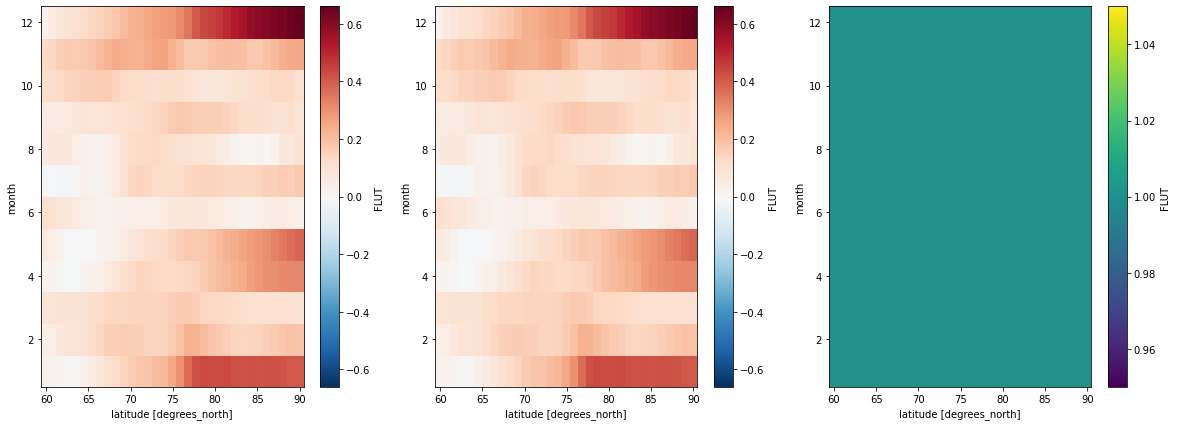

In [14]:
test_fig,test_axs = plt.subplots(nrows=1,ncols=3,figsize=(20,7))

empty.plot(ax=test_axs[0])
olr_trends.plot(ax=test_axs[1])

(olr_trends==empty).plot(ax=test_axs[2])

#### Compute trends in zonally averaged ASR

In [47]:
_fsnt_all= xr.open_mfdataset(ex_files['FSNT'])

In [49]:
_fsnt_all.time_bnds

<xarray.DataArray 'time_bnds' (time: 1932, nbnd: 2)>
dask.array<concatenate, shape=(1932, 2), dtype=object, chunksize=(1032, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1920-02-01 00:00:00 ... 2081-01-01 00:00:00
Dimensions without coordinates: nbnd
Attributes:
    long_name:  time interval endpoints

In [58]:
# Why doesn't the time chunking stick around?
# _solin = xr.open_mfdataset(ex_files['SOLIN'])['SOLIN'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))
# _fsnt = xr.open_mfdataset(ex_files['FSNT'])['FSNT'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))
_fsntoa_i = xr.open_mfdataset(ex_files['FSNTOA'])
_fsntoa = fix_cesm_time(_fsntoa_i)['FSNTOA'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))

# _asr = _fsnt
_asr = _fsntoa # This is right, right?

_fsnt.close()
_fsntoa.close()

The ASR is the net TOA SW irradiance. But this variable is definted w.r.t. top-of-model and top-of-atmosphere.

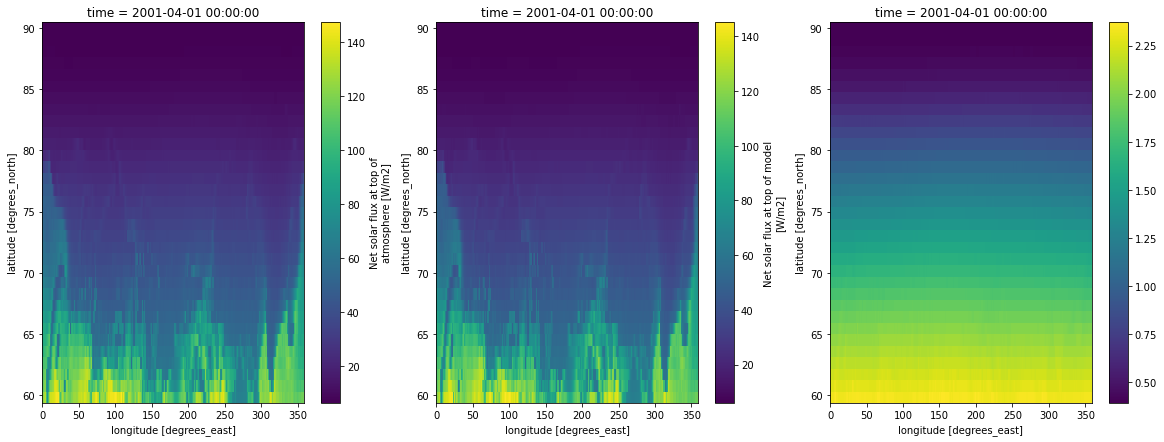

In [17]:
test_fig2,test_axs2 = plt.subplots(nrows=1,ncols=3,figsize=(20,7))

# _solin[3].plot(ax=test_axs2[0])
_fsntoa[3].plot(ax=test_axs2[0])
_fsnt[3].plot(ax=test_axs2[1])

(_fsntoa[3] - _fsnt[3]).plot(ax=test_axs2[2])

#### This is looking correct now, Greenland is highly reflective.

A further check would be to use clear-sky values (FSNTOAC) because then clouds are removed.

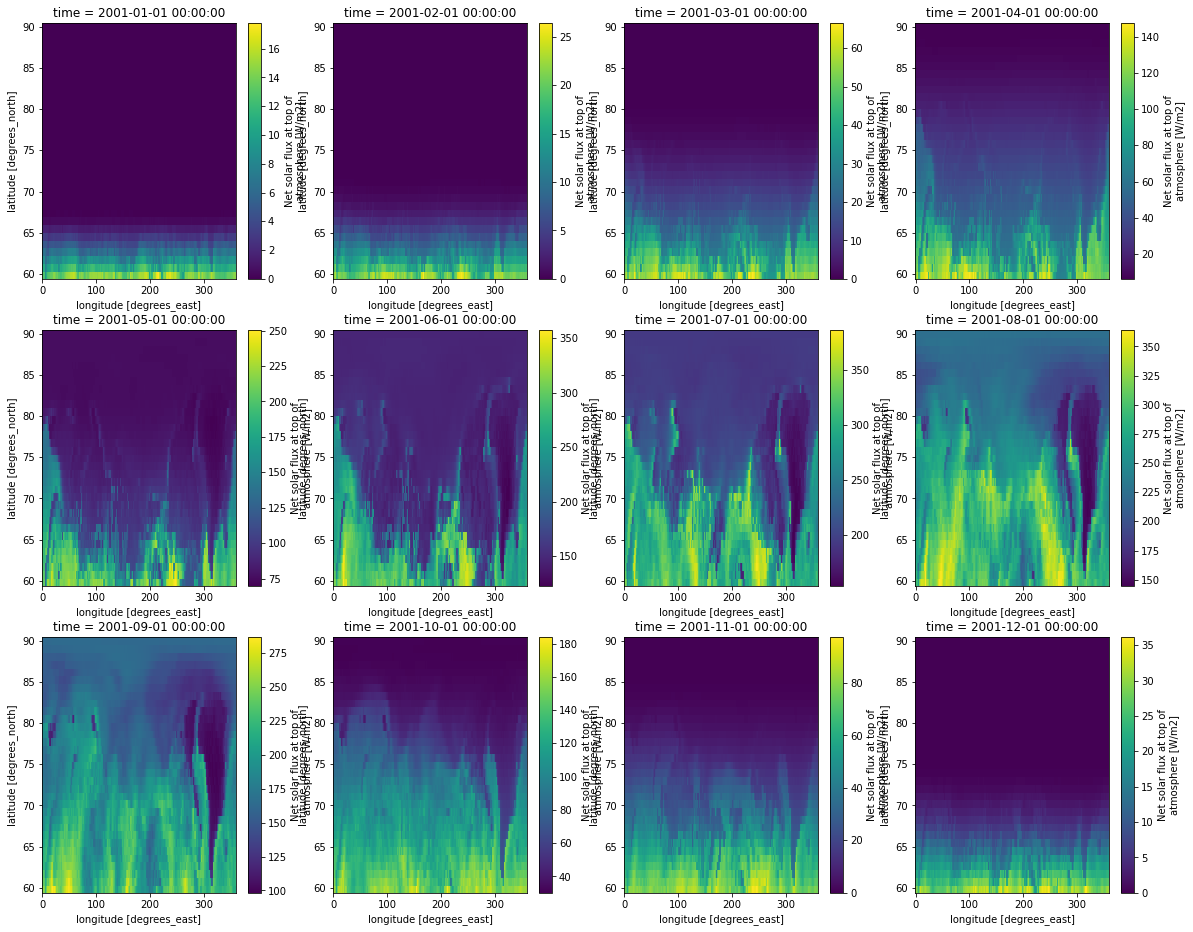

In [18]:
asr_sanity_plot,asr_axs = plt.subplots(3,4,figsize=(20,16))

axs_f = asr_axs.flat

for _month,_ax in zip(_asr,axs_f):
    
    _month.plot(ax=_ax)
#     print(_month)
#     break

In [59]:
asr_trends,asr_statsig,asr_notnull = compute_trends_n_signif2(_asr.mean('lon'))

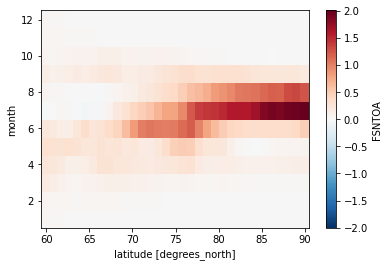

In [60]:
asr_trends.plot()

#### Compute trends in zonally averaged surface temperature

In [61]:
# Why doesn't the time chunking stick around?
_ts_i = xr.open_mfdataset(ex_files['TS'])
_ts = fix_cesm_time(_ts_i)['TS'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))

In [63]:
ts_trends,ts_statsig,ts_notnull = compute_trends_n_signif2(_ts.mean('lon'))

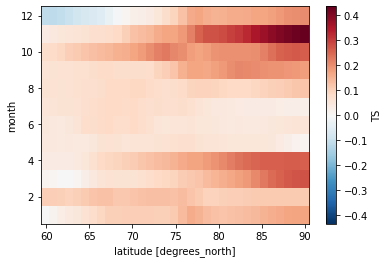

In [64]:
ts_trends.plot()

#### Compute trends in zonally averaged sea ice fraction

In [66]:
# Why doesn't the time chunking stick around?
_seaice_i = xr.open_mfdataset(ex_files['ICEFRAC'])
_seaice = fix_cesm_time(_seaice_i)['ICEFRAC'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(59,None))*100

In [67]:
seaice_trends,seaice_statsig,seaice_notnull = compute_trends_n_signif2(_seaice.mean('lon'))

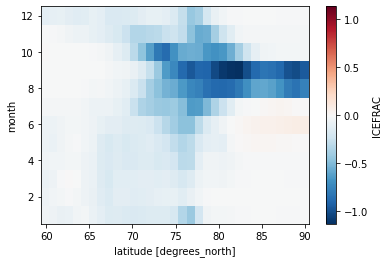

In [68]:
seaice_trends.plot()

### Plot summary data

#### Wrap data for better visualization

In [69]:
ts_trends_wrapped = xr.concat([ts_trends,ts_trends[0].assign_coords({'month':13})],dim='month')
ts_statsig_wrapped = xr.concat([ts_statsig,ts_statsig[0].assign_coords({'month':13})],dim='month')

seaice_trends_wrapped = xr.concat([seaice_trends,seaice_trends[0].assign_coords({'month':13})],dim='month')
seaice_statsig_wrapped = xr.concat([seaice_statsig,seaice_statsig[0].assign_coords({'month':13})],dim='month')

asr_trends_wrapped = xr.concat([asr_trends,asr_trends[0].assign_coords({'month':13})],dim='month')
asr_statsig_wrapped = xr.concat([asr_statsig,asr_statsig[0].assign_coords({'month':13})],dim='month')

olr_trends_wrapped = xr.concat([olr_trends,olr_trends[0].assign_coords({'month':13})],dim='month')
olr_statsig_wrapped = xr.concat([olr_statsig,olr_statsig[0].assign_coords({'month':13})],dim='month')

In [41]:
sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43026136111758173, 0.6200066482697917, 0.6787801878373952),
 (0.6085255804707219, 0.7412795877319109, 0.7824000973141302),
 (0.786789799823862, 0.86255252719403, 0.8860200067908652),
 (0.95, 0.95, 0.95),
 (0.954577257933482, 0.7665309859226215, 0.7803256889894359),
 (0.9197182699854205, 0.5873587656270927, 0.6117400023569117),
 (0.884859282037359, 0.40818654533156384, 0.4431543157243877),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

In [27]:
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

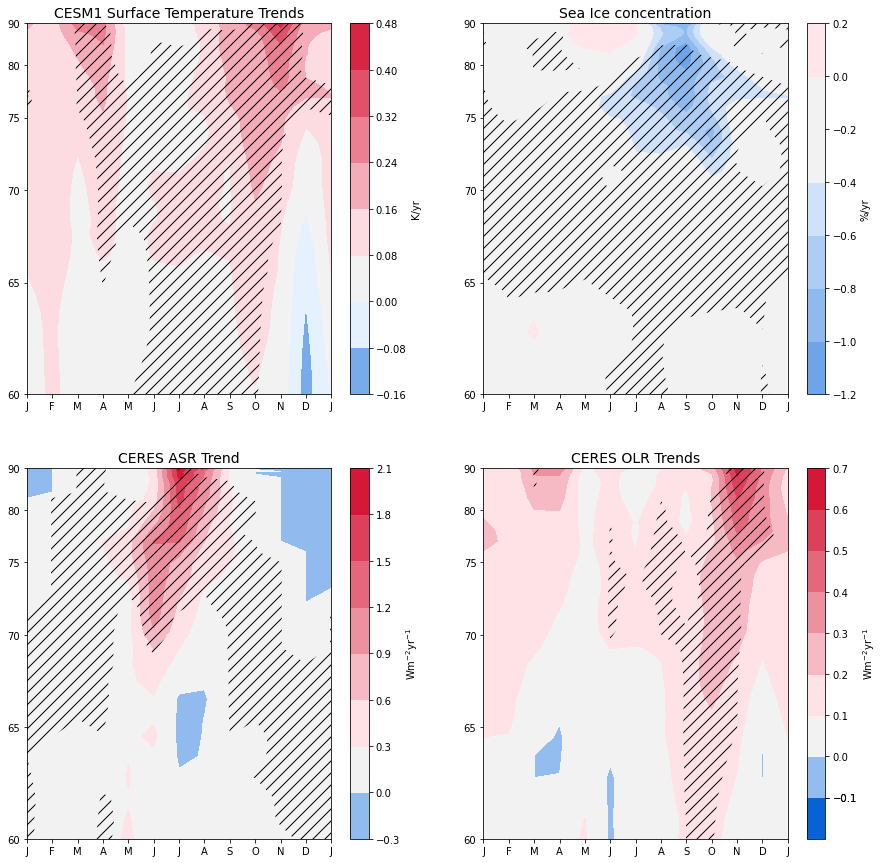

In [70]:
fig1,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

axes = axs.flat

ytick_labels = np.array([60,65,70,75,80,90])
yticks = np.sin(np.pi*ytick_labels/180)

xtick_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
xticks = np.arange(1,13.01,1)

# Set axis ticks accounting for area weighting
for _ax in axes:
    _ax.set_ylim(np.sin(np.pi/3),1)
    _ax.set_yticks(yticks)
    _ax.set_yticklabels(ytick_labels)
    _ax.set_xticks(xticks)
    _ax.set_xticklabels(xtick_labels)
    
lat_weighted0 = np.sin(np.pi/180*ts_trends['lat'])
im0 = axes[0].contourf(ts_trends_wrapped['month'],lat_weighted0,ts_trends_wrapped.transpose('lat','month'),
                       cmap=palette,norm=MidpointNormalize(midpoint=0,vmin=-0.2,vmax=0.5))
stip = axes[0].contourf(ts_statsig_wrapped['month'],lat_weighted0,ts_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[0].set_title('CESM1 Surface Temperature Trends',fontsize=14)
plt.colorbar(im0,ax=axes[0],label='K/yr')

lat_weighted1 = np.sin(np.pi/180*seaice_trends['lat'])
im1 = axes[1].contourf(seaice_trends_wrapped['month'],lat_weighted1,seaice_trends_wrapped.transpose('lat','month'),
                       cmap=palette,norm=MidpointNormalize(midpoint=0,vmin=-1.75,vmax=0.5))
stip = axes[1].contourf(seaice_statsig_wrapped['month'],lat_weighted1,seaice_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[1].set_title('Sea Ice concentration',fontsize=14)
plt.colorbar(im1,ax=axes[1],label='%/yr')

lat_weighted2 = np.sin(np.pi/180*asr_trends['lat'])
im2 = axes[2].contourf(asr_trends_wrapped['month'],lat_weighted2,asr_trends_wrapped.transpose('lat','month'),
                       cmap=palette,norm=MidpointNormalize(midpoint=0,vmin=-0.3,vmax=2.1))#,levels=np.arange(-1.0,1.01,0.2))
stip = axes[2].contourf(asr_statsig_wrapped['month'],lat_weighted2,asr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[2].set_title('CERES ASR Trend',fontsize=14)
plt.colorbar(im2,ax=axes[2],label='Wm$^{-2}$yr$^{-1}$')

lat_weighted3 = np.sin(np.pi/180*olr_trends['lat'])
im3 = axes[3].contourf(olr_trends_wrapped['month'],lat_weighted3,olr_trends_wrapped.transpose('lat','month'),
                       cmap=palette,norm=MidpointNormalize(midpoint=0,vmin=-0.1,vmax=0.7),levels=np.arange(-0.2,0.71,0.1))
stip = axes[3].contourf(olr_statsig_wrapped['month'],lat_weighted3,olr_statsig_wrapped.transpose('lat','month'), colors='none',levels=[0,95,100],
                        hatches=[None,'//'],extend='neither')
axes[3].set_title('CERES OLR Trends',fontsize=14)
plt.colorbar(im3,ax=axes[3],label='Wm$^{-2}$yr$^{-1}$')


In [74]:
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def my_floor(a, precision=0):
    return np.round(a - 0.5 * 10**(-precision), precision)

In [83]:
my_ceil(np.max(olr_trends_wrapped.values),precision=1)

0.7

In [78]:
my_ceil(1.533,precision=2)

1.54

In [73]:
np.ceil(1.75,)

TypeError: return arrays must be of ArrayType

In [43]:
mayfiles = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.???.cam.h0.%s.192001-200512.nc' % (cesmle_path,model_variables[1],model_variables[1]))

In [44]:
mayfiles.sort()
mayfiles

['/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.003.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.004.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.005.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.006.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//LANDFRAC/b.e11.B20TRC5CNBDRD.f09_g16.007.cam.h0.LANDFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections

In [42]:
mayfiles.sort()
mayfiles

['/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.003.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.004.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.005.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.006.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly//ICEFRAC/b.e11.B20TRC5CNBDRD.f09_g16.007.cam.h0.ICEFRAC.192001-200512.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM

In [35]:
all_ens

['b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h0.ICEFRAC.208101-210012.nc',
 'b.e11.B20TRC5CNBDRD.f09_g16.OIC.002.cam.h0.ICEFRAC.192001-199912.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.033.cam.h0.ICEFRAC.200601-208012.nc',
 'b.e11.B20TRLENS_RCP85.f09_g16.xbmb.009.cam.h0.ICEFRAC.192001-202912.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.027.cam.h0.ICEFRAC.208101-210012.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.034.cam.h0.ICEFRAC.200601-210012.nc',
 'b.e11.B20TRLENS_RCP85.f09_g16.xghg.008.cam.h0.ICEFRAC.200601-208012.nc',
 'b.e11.B1850C5CN.f09_g16.005.cam.h0.ICEFRAC.200001-209912.nc',
 'b.e11.B20TRC5CNBDRD.f09_g16.035.cam.h0.ICEFRAC.192001-200512.nc',
 'f.e11.F1850C5CN.f09_f09.001.cam.h0.ICEFRAC.200001-209912.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.014.cam.h0.ICEFRAC.208101-210012.nc',
 'b.e11.BRCP85C5CNBDRD.f09_g16.006.cam.h0.ICEFRAC.208101-210012.nc',
 'b.e11.B20TRLENS_RCP85.f09_g16.xghg.016.cam.h0.ICEFRAC.200601-208012.nc',
 'b.e11.B20TRC5CNBDRD.f09_g16.020.cam.h0.ICEFRAC.192001-200512.nc',
 'b.e11.B20TRLENS_RCP85.f

In [29]:
ls $cesmle_path

ABSORB/          dst_c3DDF/         num_a2DDF/    so4_a3_SRF/
ANRAIN/          dst_c3SFWET/       num_a2_logm/  so4_c1/
ANSNOW/          DTCOND/            num_a2_logv/  so4_c1DDF/
AODABS/          DTV/               num_a2SFWET/  so4_c1SFWET/
AODDUST1/        EXTINCT/           num_a3DDF/    so4_c2/
AODDUST2/        FICE/              num_a3_logm/  so4_c2DDF/
AODDUST3/        FISCCP1_COSP/      num_a3_logv/  so4_c2SFWET/
AODVIS/          FLDS/              num_a3SFWET/  so4_c3/
AQRAIN/          FLNS/              num_c1/       so4_c3DDF/
AQSNOW/          FLNSC/             num_c1DDF/    so4_c3SFWET/
AREI/            FLNT/              num_c1SFWET/  soa_a1DDF/
AREL/            FLNTC/             num_c2/       soa_a1_logm/
AWNC/            FLUT/              num_c2DDF/    soa_a1_logv/
AWNI/            FLUTC/             num_c2SFWET/  soa_a1SFWET/
bc_a1DDF/        FREQI/             num_c3/       soa_a1_SRF/
bc_a1_logm/      FREQL/             num_c3DDF/    soa_a2DDF/
bc_a1_logv/      FR

In [10]:
ls $cesmle_path/LENS-CMIP5-O3/atm/proc/tseries/monthly/LANDFRAC

b.e11.BRCP85C5CNBDRD.f09_g16.034_CMIP5-O3.cam.h0.LANDFRAC.200601-210012.nc
b.e11.BRCP85C5CNBDRD.f09_g16.035_CMIP5-O3.cam.h0.LANDFRAC.200601-210012.nc


In [15]:
ls $cesmle_path/LENS-CMIP5-O3/atm/proc/tseries/monthly/CLDTOT

b.e11.BRCP85C5CNBDRD.f09_g16.034_CMIP5-O3.cam.h0.CLDTOT.200601-210012.nc
b.e11.BRCP85C5CNBDRD.f09_g16.035_CMIP5-O3.cam.h0.CLDTOT.200601-210012.nc


In [12]:
ls $cesmle_path/CESM-CAM5-AMIP-SF

f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_1920sst.001/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.001/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.002/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.003/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.004/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.005/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.006/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.007/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.008/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.009/
f.e11.FAMIPC5CN_RCP85.f09_f09.1920emis_AERBMBsst.010/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.001/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.002/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.003/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.004/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.005/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.006/
f.e11.FAMIPC5CN_RCP85.f09_f09.AERBMBemis_1920sst.007/
f.e11.FAMIPC5CN_RCP85.f09_f09.

In [20]:
ls $cesmle_path/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/CLDTOT

b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.040001-049912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.050001-059912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.060001-069912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.070001-079912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.080001-089912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.090001-099912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.100001-109912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.110001-119912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.120001-129912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.130001-139912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.140001-149912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.150001-159912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.160001-169912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.170001-179912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.180001-189912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.190001-199912.nc
b.e11.B1850C5CN.f09_g16.005.cam.h0.CLDTOT.200001-209912.